### Phys 629, Fall 2023, University of Mississippi


# Lecture 8, Chapter 4: Classical Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 4.

***Exercises required for class participation are in <font color='red'>red</font>.***

## Statistical Inference <a class="anchor" id="one"></a>

Statistical *inference* is about drawing conclusions from data, specifically determining the properties of a population by data sampling.

Three examples of inference are:
1. What is the best estimate for a model parameter?
2. How confident are we about our result?
3. Are the data consistent with a particular model/hypothesis?

### Some Terminology

* We typically study the properties of some ***population*** by measuring ***samples*** from that population. The population doesn't have to refer to different objects. E.g., we may be (re)measuring the position of an object at rest; the population is the distribution of (an infinite number of) measurements smeared by the uncertainty, and the sample are the measurement we've actually taken.


* A ***statistic*** is any function of the sample. For example, the sample mean is a statistic. But also, "the value of the first measurement" is also a statistic. Don't stress too much about how to make a statistic; it's just a way of summarizing data in a way that helps reveal the presence of a signal. We will meet ways of finding the optimal statistic for a given scenario.


* To conclude something about the population from the sample, we develop ***estimators***. An estimator is a statistic, a rule for calculating an estimate of a given quantity based on observed data.


* There are ***point*** and ***interval estimators***. The point estimators yield single-valued results (example: the position of an object), while with an interval estimator, the result would be a range of plausible values (example: confidence interval for the position of an object).


* Measurements have **uncertainties** (not errors) and we need to account for these (sometimes they are unknown). Data are not variables but fixed values.

### Frequentist vs. Bayesian Inference

There are two major statistical paradigms that address the statistical inference questions: 
- the **classical**, or **frequentist** paradigm,
- the **Bayesian** paradigm.

While most of statistics and machine learning is based on the classical paradigm, Bayesian techniques are being embraced by the statistical and scientific communities at an ever-increasing pace...especially in astrophysics.

#### Key differences
- **Definition of probabilities**:
    - In ***frequentist inference***, probabilities describe the ***relative frequency of events*** over repeated experimental trials. 
    - In ***Bayesian infernece***, probabilities instead quantify our ***subjective belief about experimental outcomes, model parameters, or even models themselves***. 
    
    
- **Quantifying uncertainty**:
    - In ***frequentist inference*** we have ***confidence levels*** that describe the distribution of the measured parameter from the data around the true value.
    - In ***Bayesian inference*** we have ***credible regions*** derived from posterior probabilitiy distributions (we'll meet these later). These encode our "***belief spread***" in model parameters.

#### Example
Let's say that you get the results of an IQ test.  Any given test result might not give you your "real" IQ (whatever that means anyway...).  But it gives us a way to *estimate* it (and the possible range of values).  
- For a frequentist, the best estimator is the average of many test results.  So, if you took 5 IQ tests and got a sample mean of 160, then that would be the estimator of your true IQ.
- On the other hand, a Bayesian would say: "*but wait, I know that IQ tests are calibrated to have a mean of 100 with a standard deviation of 15 points*".  So they will use that as "prior" information, which is important here since 160 is a 4$\sigma$ outlier. 

There's nothing mysterious about priors. It simply encodes any previous knowledge or information we have about our experiment.

The following article provides a nice example that is visualized below (without the detailed math) [Efron 1978](http://www.jstor.org/stable/2321163?seq=1#page_scan_tab_contents)

<font color='red'># Execute this cell</font>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=10, usetex=True)

<font color='red'>Complete and execute the following cell. It will show the simple average of IQ tests, the prior distribution one would use in a Bayesian analysis, and the final Bayesian posterior "belief" distribution.</font>

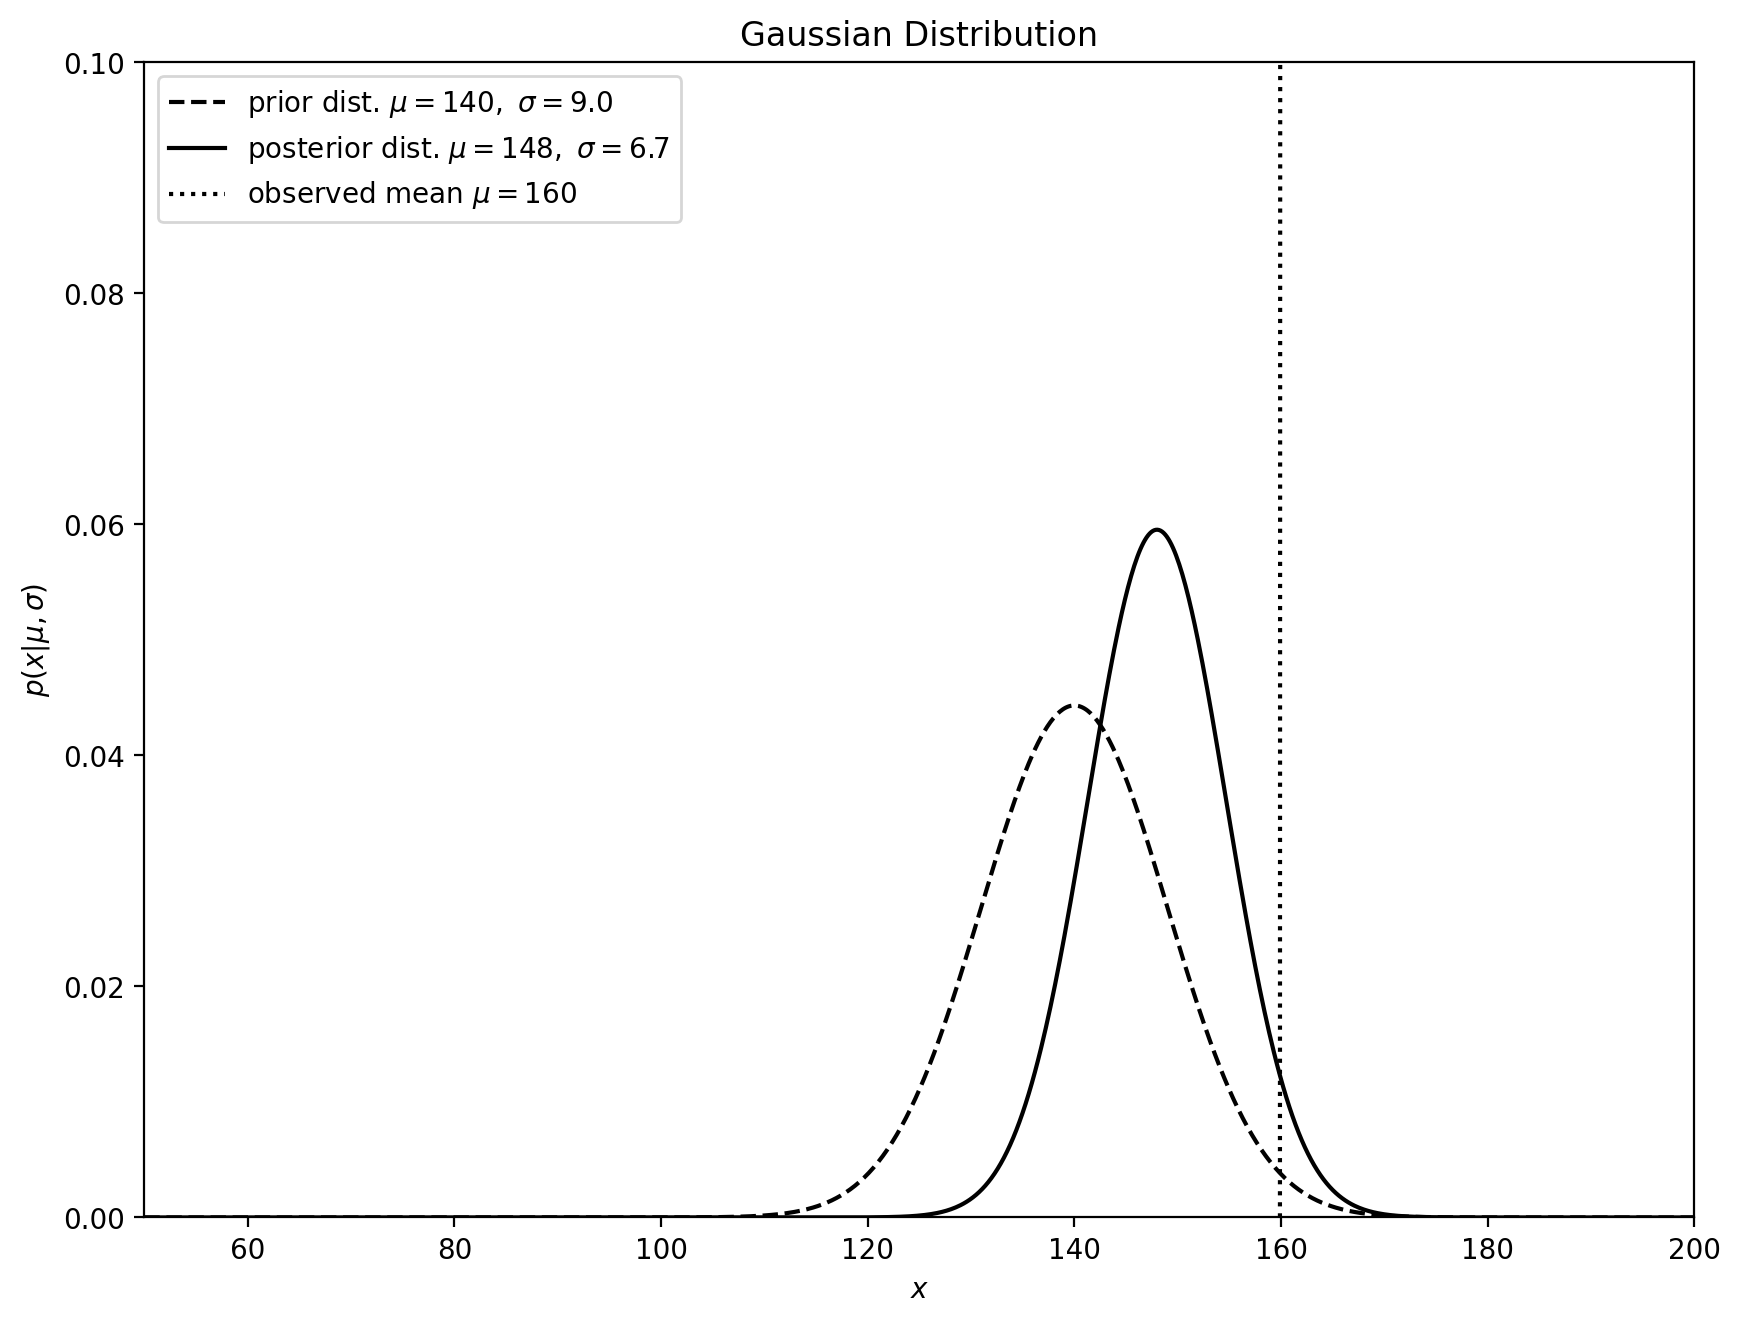

In [4]:
# Define the distributions to be plotted
sigma_values = [9, 6.7, 1] #complete with the prior width of IQ distribution
linestyles = ['--', '-', ':']
mu_values = [140, 148, 160] #complete with the prior mean of IQ distribution
labeltext = ['prior dist.', 
             'posterior dist.', 
             'observed mean']
xplot = np.linspace(50, 200, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))

for sigma, ls, mu, lab in zip(sigma_values, 
                              linestyles, 
                              mu_values, 
                              labeltext):
    
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    if sigma > 1:
        plt.plot(xplot, dist.pdf(xplot), 
                 ls=ls, c='black',
                 label=r'%s $\mu=%i,\ \sigma=%.1f$' % (lab, mu, sigma))
    else:
        plt.plot([159.9, 160.1], [0, 0.8], 
                 ls=ls, color='k', label=r'%s $\mu=%i$' % (lab, mu))
        
plt.xlim(50, 200)
plt.ylim(0, 0.1)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()

The end result (skipping over the detailed math) is that the Bayesian estimate of the IQ is not 160, but rather 148, or more specifically that $p(141.3\le \mu \le 154.7 \, | \, \overline{x}=160) = 0.683$. This estimate incorporates the prior information of how the IQ distribution is calibrated.

This all seems totally fine; where's the controvery with Bayesian methods? The controvery arises when we don't know the prior distribution, or when the parameter is fixed but we are trying to experimentally verify it (e.g., the speed of light). We'll return to this.

## Maximum Likelihood Estimation (MLE) <a class="anchor" id="two"></a>

Let's talk about maximum likelihood estimation ($\S 4.2$ in the textbook), which is relevant to both Bayesian and Frequentist approaches.

### Maximum Likelihood Approach

Maximum likelihood estimation follows this blueprint:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, the data are a measurement of some quantity with Gaussian random uncertainties (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.


2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M)$. This search yields the MLE *point estimates*, $\boldsymbol{\theta^0}$.


3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta^0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation (we'll come to these later).


4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

### Example: Measuring the Position of a Quasar

Let's assume we wish to estimate the position $x$ of a quasar from a series of individual astrometric measurements.

1. We adopt a model where the observed quasar does not move, and has individual measurement uncertainties 
2. We derive the expression for the likelihood of there being a quasar at position $x_0$ that gives rise to our individual measurements. We find the value of $\hat x_0$ for which our observations are maximally likely.
3. We determine the uncertainties (confidence intervals) on our measurement.
4. We test whether what we've observed is consistent with our adopted model. For example, is it possible that the quasar was really a misidentified star with measurable proper motion?

Note: in the text to come, we will use $\mu$ instead of $x_0$ to denote the true position of the quasar. This is to avoid potential confusion with the first (or zeroth) measurement of $x$.

<font color='red'>Stop here for a minute and talk with your colleagues. What likelihood function would you choose as an approximation for this situation? What underlying assumptions did you make?</font>

We can use a Gaussian Likelihood. Here we assume that the measurement errors are normally distributed (Gaussian). Therefore, the likelihood function would follow a Gaussian distribution centered around the true position $x_{0}$ with a standard deviation equal to the measurement uncertainty. The following assumptions were made: 

* The measurement errors are independent and identically distributed 
* The measurement errors are normally distributed
* The quasar's position 𝑥0 does not change during the observation period
